In [49]:
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from PIL import Image
from torchvision import transforms

from utils.data_loading import BasicDataset
from unet import UNet
from utils.utils import plot_img_and_mask

In [70]:
n_classes = 7

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

net = UNet(n_channels=3, n_classes=n_classes)
net.to(device=device)
state_dict = torch.load(os.path.join(os.getcwd(), "checkpoint_epoch4_c.pth"), map_location=device)
mask_values = state_dict.pop('mask_values', [0, 1])
net.load_state_dict(state_dict)

<All keys matched successfully>

In [71]:
net.eval()

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [72]:
# 원본 이미지 전처리
img_f = Image.open(os.path.join("image_test", "IMG_D_A1_000001.jpg")).resize((572, 572))
img = torch.from_numpy(BasicDataset.preprocess(None, img_f, 1, is_mask=False))
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(img).cpu()
    
print(output.shape)

torch.Size([1, 7, 572, 572])


In [73]:
import torch.onnx as onnx

# 모델을 ONNX로 변환
dummy_input = torch.empty(1,3, 572, 572, dtype=torch.float32)
onnx_path = "model.onnx"

# PyTorch -> ONNX 변환
try:
#     onnx.export(net, dummy_input, onnx_path, input_names=['input'], output_names=['output'], dynamic_axes={'input':[0, 1, 2, 3]})
    onnx.export(net, dummy_input, onnx_path, input_names=['input'], output_names=['output'], verbose=True)
except Exception as e:
    print(e)

============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================



In [74]:
import onnx

# ONNX 모델 로드
onnx_model = onnx.load("model.onnx")

# 모델 체크
try:
    onnx.checker.check_model(onnx_model)
except onnx.checker.ValidationError as e:
    print("The model is invalid: %s" % e)
else:
    print("The model is valid!")

The model is valid!


In [75]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("model.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# 원본 이미지 전처리
img_f = Image.open(os.path.join("image_test", "IMG_D_A1_000001.jpg")).resize((572, 572))
img = torch.from_numpy(BasicDataset.preprocess(None, img_f, 1, is_mask=False))
img = img.unsqueeze(0)
img = img.to(device=device, dtype=torch.float32)

with torch.no_grad():
    output = net(img).cpu()

# ONNX 런타임에서 계산된 결과값
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(img)}
ort_outs = ort_session.run(None, ort_inputs)

# ONNX 런타임과 PyTorch에서 연산된 결과값 비교
np.testing.assert_allclose(to_numpy(output), ort_outs[0], rtol=1e-03, atol=1e-05)

print("Exported model has been tested with ONNXRuntime, and the result looks good!")

Exported model has been tested with ONNXRuntime, and the result looks good!


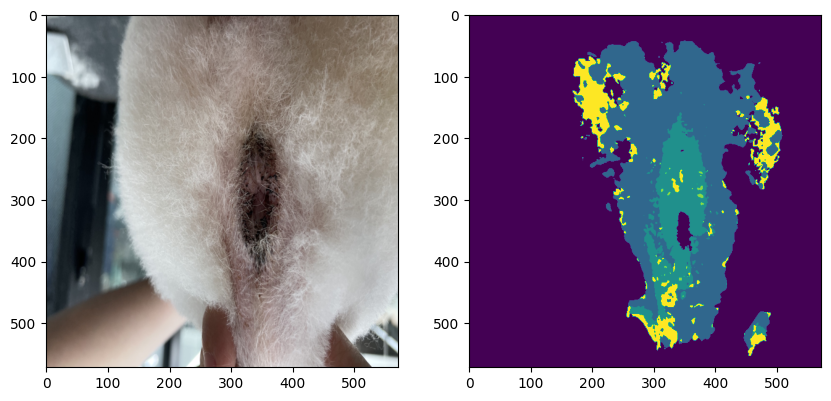

In [77]:
import matplotlib.pyplot as plt

pil_image = np.array(ort_outs)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(img_f)
plt.subplot(1, 2, 2)
plt.imshow(pil_image[0][0].argmax(axis=0))

In [ ]:
from onnx.tools import net_drawer

# 모델 그래프 시각화
graph = net_drawer.GetPydotGraph(onnx_model.graph, rankdir="TB")
graph.write_png("model_graph.png")

# tflite Test

In [78]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from PIL import Image

In [79]:
interpreter = tf.lite.Interpreter(model_path='4c_16f.tflite')
interpreter.allocate_tensors()

In [91]:
test_img_origin = Image.open(os.path.join(os.getcwd(), "image_test", 'IMG_D_A1_000001.jpg')).resize((572, 572))
test_img = np.array(test_img_origin).astype(np.float32) / 255.0
test_img = np.expand_dims(test_img, axis=0)
print(test_img.shape)

(1, 572, 572, 3)


In [87]:
input_details = interpreter.get_input_details()
input_details

[{'name': 'inputs_0',
  'index': 0,
  'shape': array([  1, 572, 572,   3]),
  'shape_signature': array([  1, 572, 572,   3]),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [88]:
interpreter.set_tensor(input_details[0]['index'], tf.convert_to_tensor(test_img))

In [89]:
interpreter.invoke()

[0 2 3 5 6]
[234330  61580  17691    257  13326]


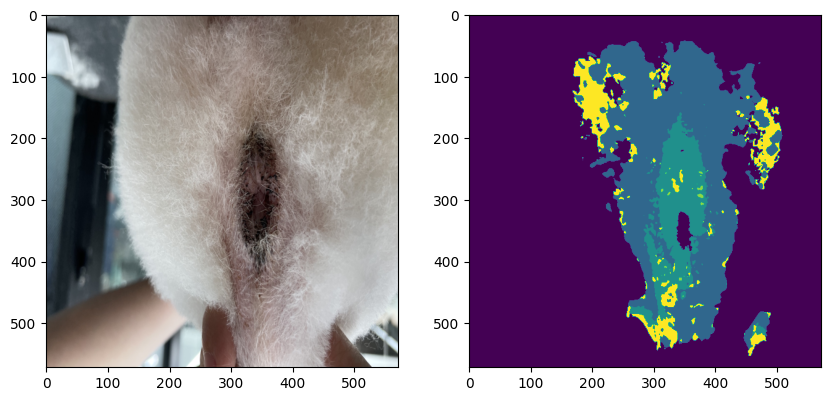

In [93]:
output_index = interpreter.get_output_details()[0]['index']
output_data = interpreter.get_tensor(output_index)
output = np.array(output_data[0]).argmax(axis=2)

unique, counts = np.unique(output, return_counts = True)
print(unique)
print(counts)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(test_img_origin)
plt.subplot(1, 2, 2)
plt.imshow(output)